In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import integrate, optimize

In [3]:
from matplotlib import pyplot as plt

In [4]:
from matplotlib import rc

In [5]:
rc('font',size=16)

In [6]:
s = 8
n = 1
Gamma = (n+1)/n
K = np.exp(s*(Gamma-1))
Pc = 1e-2
#Gamma = 2
#K = 1
#rhoc = 0.42
#Pc = K*rhoc**Gamma
print(s,K,n,Gamma)
def get_rho_adm(P):
    rho = (P/K)**(1./Gamma)
    eps = (K / (Gamma - 1)) * (P/K)**((Gamma - 1) / Gamma)
    return rho*(1 + eps)

8 2980.9579870417283 1 2.0


In [7]:
data = np.loadtxt('tov.dat')

In [8]:
rho_adm = data[...,4]
alpha = data[...,3]

In [9]:
r = data[...,0]
dr = r[1] - r[0]
print(dr)
PMIN = 1e-9
def rhs(r, u):
    m, p, phi = u
    rho_adm = get_rho_adm(p)
    rhs = np.empty_like(u)
    if r == 0:
        rhs[0] = 0
        rhs[1] = 0
        rhs[2] = 0
    elif r <= dr:
        rhs[0] = 4*np.pi*r*r*rho_adm
        dphidr = (4*np.pi*rho_adm*r/3. + 4*np.pi*r*p)/(1 - 8*np.pi*r*r/3)
        rhs[1] = -(rho_adm + p)*dphidr
        rhs[2] = dphidr
    else:
        rhs[0] = 4*np.pi*r*r*rho_adm
        dphidr = (m + 4*np.pi*(r**3)*p)/(r*(r-2*m))
        rhs[1] = -(rho_adm + p)*dphidr
        rhs[2] = dphidr
    if p < PMIN:
        rhs[0] = 0
        rhs[1] = 0
    return rhs

def residual(phi0):
    integrator = integrate.ode(rhs)
    integrator.set_integrator('lsoda')
    integrator.set_initial_value(np.array([0,Pc,phi0]))
    integrator.integrate(r[-1])
    m = integrator.y[0]
    phi = integrator.y[-1]
    alpha_tov = np.exp(phi)
    alpha_target = alpha[-1]#(1 - 2*m/r[-1])
    residual = alpha_tov - alpha_target
    #print(phi,alpha_tov,alpha_target,residual)
    return residual

result = optimize.root_scalar(residual,x0=0.5*np.log(alpha[0]),x1=np.log(alpha[0]))
print(result)
phi0 = result.root

tov_state = np.empty((r.shape[0],3))
tov_state[0] = np.array([0,Pc,phi0])
integrator = integrate.ode(rhs)
integrator.set_integrator('lsoda')
integrator.set_initial_value(np.array([0,Pc,phi0]))

for i,rr in enumerate(r[1:]):
    integrator.integrate(rr)
    tov_state[i+1] = integrator.y

0.00243904818583596
      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: -2.7249654254291373


<ipython-input-6-3daf5d8390f3>:12: RuntimeWarning: invalid value encountered in double_scalars
  rho = (P/K)**(1./Gamma)
<ipython-input-6-3daf5d8390f3>:13: RuntimeWarning: invalid value encountered in double_scalars
  eps = (K / (Gamma - 1)) * (P/K)**((Gamma - 1) / Gamma)


In [10]:
m = tov_state[:,0]
P_tov = tov_state[:,1]
rho_adm_tov = get_rho_adm(P_tov)
phi_tov = tov_state[:,2]
alpha_tov = np.exp(phi_tov)

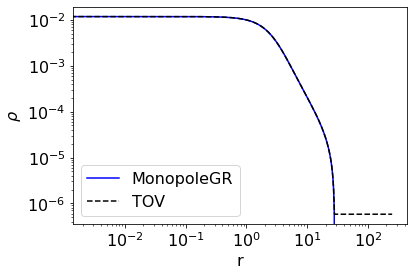

In [11]:
plt.loglog(r, rho_adm,'b-',label='MonopoleGR')
plt.plot(r,rho_adm_tov,'k--',label='TOV')
plt.xlabel('r')
plt.ylabel(r'$\rho$')
plt.legend()
plt.savefig('rho.png',bbox_inches='tight')

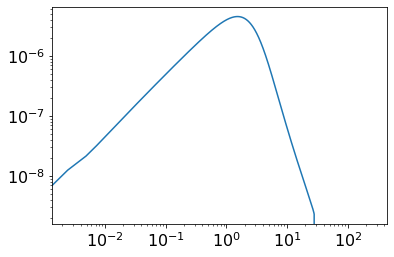

In [12]:
plt.loglog(r, rho_adm - rho_adm_tov)

<ipython-input-13-7910aca95eb9>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(r, 1./(1-(2*m/r)),'k--',label='TOV')


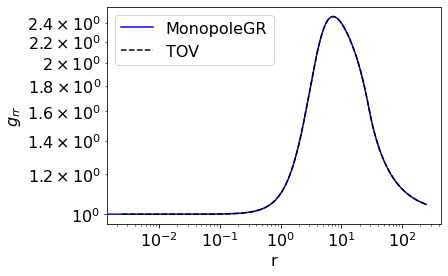

In [13]:
plt.loglog(r,data[...,1]**2,'b-',label='MonopoleGR')
plt.plot(r, 1./(1-(2*m/r)),'k--',label='TOV')
plt.legend()
#plt.ylim(0,3)
plt.xlabel('r')
plt.ylabel(r'$g_{rr}$')
plt.savefig('grr.png')

<ipython-input-14-19b6f327af4f>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(r,data[...,1]**2 - 1./(1 - 2*(m/r)))


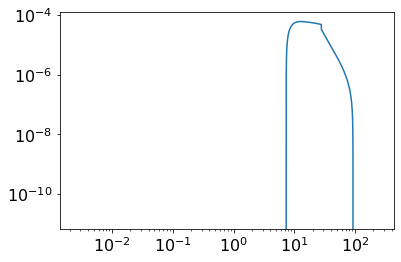

In [14]:
plt.loglog(r,data[...,1]**2 - 1./(1 - 2*(m/r)))

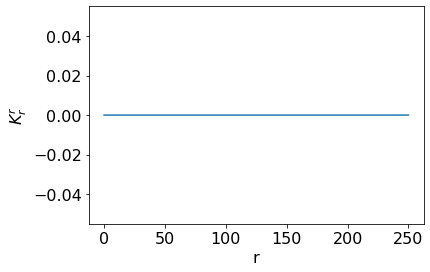

In [15]:
plt.plot(data[...,0],(data[...,2]))
plt.xlabel('r')
plt.ylabel(r'$K^r_r$')
plt.savefig('Krr.png')

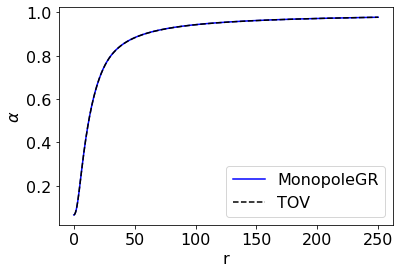

In [16]:
plt.plot(r,alpha,'b-',label='MonopoleGR')
plt.plot(r,alpha_tov,'k--',label='TOV')
#plt.plot(r, 1-2*m/r)
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\alpha$')
plt.savefig('alpha.png',bbox_inches='tight')

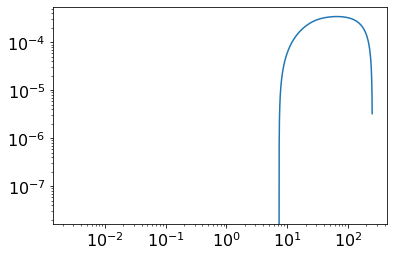

In [27]:
plt.loglog(r, alpha - alpha_tov)

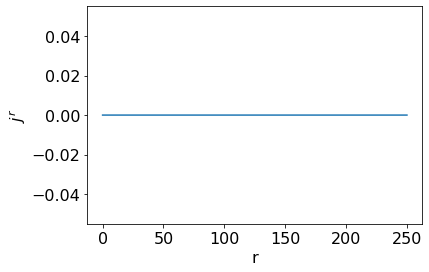

In [17]:
plt.plot(data[...,0],data[...,5])
plt.xlabel('r')
plt.ylabel(r'$j^r$')
plt.savefig('jr.png',bbox_inches='tight')

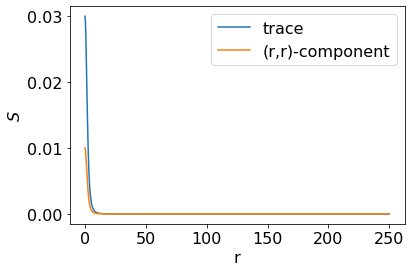

In [18]:
plt.plot(data[...,0],data[...,6],label='trace')
plt.plot(data[...,0],data[...,7],label='(r,r)-component')
plt.xlabel('r')
plt.ylabel(r'$S$')
plt.legend()
plt.savefig('S.png')

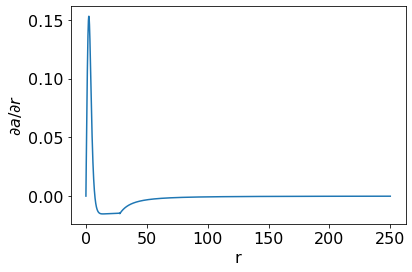

In [19]:
plt.plot(data[...,0],data[...,8])
plt.xlabel('r')
plt.ylabel(r'$\partial a/\partial r$')
plt.savefig('dadr.png',bbox_inches='tight')

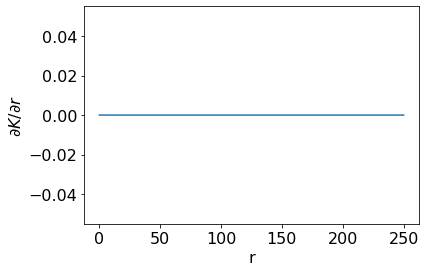

In [20]:
plt.plot(data[...,0],data[...,9])
plt.xlabel('r')
plt.ylabel(r'$\partial K/\partial r$')
plt.savefig('dKdr.png',bbox_inches='tight')

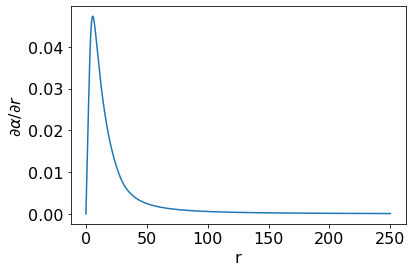

In [21]:
plt.plot(data[...,0],data[...,10])
plt.xlabel('r')
plt.ylabel(r'$\partial \alpha/\partial r$')
plt.savefig('dalphadr.png',bbox_inches='tight')

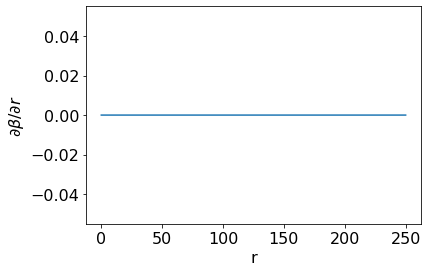

In [22]:
plt.plot(data[...,0],data[...,11])
plt.xlabel('r')
plt.ylabel(r'$\partial \beta/\partial r$')
plt.savefig('dbetadr.png',bbox_inches='tight')

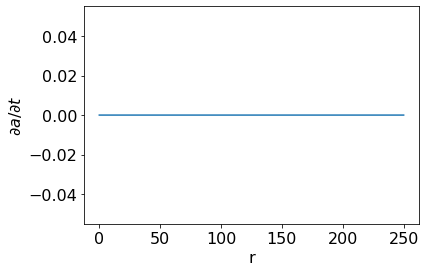

In [23]:
plt.plot(data[...,0],data[...,12])
plt.xlabel('r')
plt.ylabel(r'$\partial a/\partial t$')
plt.savefig('dadt.png',bbox_inches='tight')

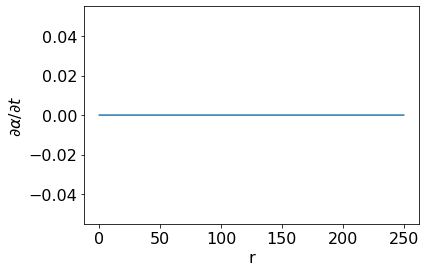

In [24]:
plt.plot(data[...,0],1e5*data[...,13])
plt.xlabel('r')
plt.ylabel(r'$\partial \alpha/\partial t$')
plt.savefig('dalphadt.png',bbox_inches='tight')

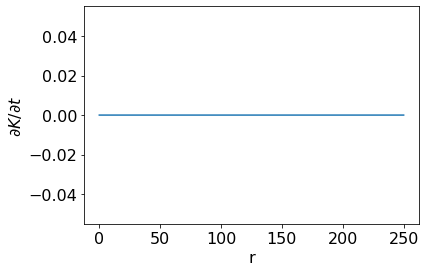

In [25]:
plt.plot(data[...,0],1e5*data[...,14])
plt.xlabel('r')
plt.ylabel(r'$\partial K/\partial t$')
plt.savefig('dKdt.png',bbox_inches='tight')

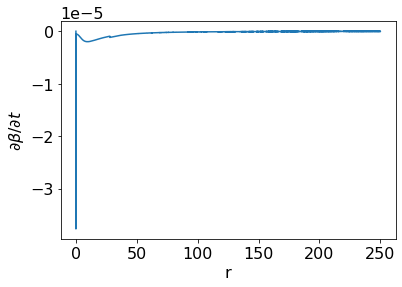

In [26]:
plt.plot(data[...,0],data[...,15])
plt.xlabel('r')
plt.ylabel(r'$\partial \beta/\partial t$')
plt.savefig('dbetadt.png',bbox_inches='tight')